# Variational CTscan imaging of FASTMRI brain dataset

### Author: M. Ravasi

Welcome to the "Deep Learning in Scientific Inverse Problems" course!

The aim of this third notebook is to apply standard variational approaches to CTscan imaging. We will be using a single brain image from the training dataset (which we will always keep in the testing dataset to provide a fair comparison of different methods). 

Two methods will be applied:

- Least-squares optimization with Laplacian regularization
- Convex optimization with isotropic Total-Variation regularization

In [1]:
#### COLAB ####
COLAB = False # Set to False or True depending if you use local or Colab env. (everything else will work automatically)

In [2]:
if COLAB:
    !apt-get install automake libtool
    !pip install astra-toolbox pylops pyproximal

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astra
import numpy as np
import matplotlib.pyplot as plt
import pylops
import torch

from scipy.sparse.linalg import lsqr
from tqdm.notebook import tqdm
from pylops.utils.dottest import dottest
from pylops.utils.metrics import snr
from pyproximal.proximal import *
from pyproximal.optimization.primal import *

from ct import astra_projector, CT2D
from plotting import plt_comparison

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# astra.test()

## Create dataset

In [4]:
# Load data
if not COLAB:
    brains = np.load('../data/brains_trainingdata.npy')
else:
    brains = np.load('/content/drive/My Drive/DA_SummerSchool_2023/brains_trainingdata.npy')
brain = brains[10]
nx, ny = brain.shape

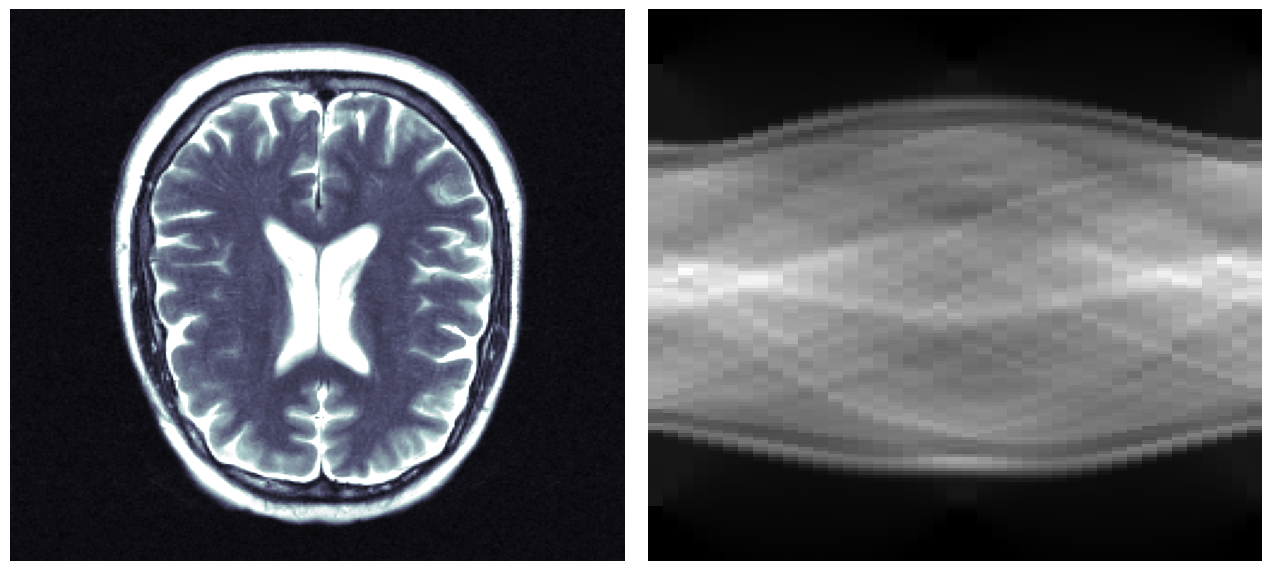

In [8]:
# Create data
nangles = 41
distdetectors = 2
ndetectors = 160

vol_geom = astra.create_vol_geom(nx, ny)
proj_geom = astra.create_proj_geom('parallel', distdetectors, ndetectors, 
                                   np.linspace(0, np.pi, nangles, False))

proj_id = astra.create_projector(astra_projector('cpu'), proj_geom, vol_geom)
sinogram_id, sinogram = astra.create_sino(brain, proj_id)

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].imshow(brain, vmin=0, vmax=.5, cmap='bone')
axs[0].axis('tight')
axs[0].axis('off')
axs[1].imshow(sinogram.T, cmap='gray')
axs[1].axis('tight')
axs[1].axis('off')
plt.tight_layout()

In [13]:
# Create operator
Cop = CT2D((nx, ny), distdetectors, ndetectors, np.linspace(0, np.pi, nangles, False), 
           projector_type=astra_projector('cpu'))
dottest(Cop, atol=1e-3, verb=True, raiseerror=False)

Dot test passed, v^H(Opu)=953.2606798166461 - u^H(Op^Hv)=953.26086444425


True

## Least-squares inversion

/Users/ravasim/Desktop/KAUST/2023/Teaching/DA_summerschool_2023/notebooks/plotting.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


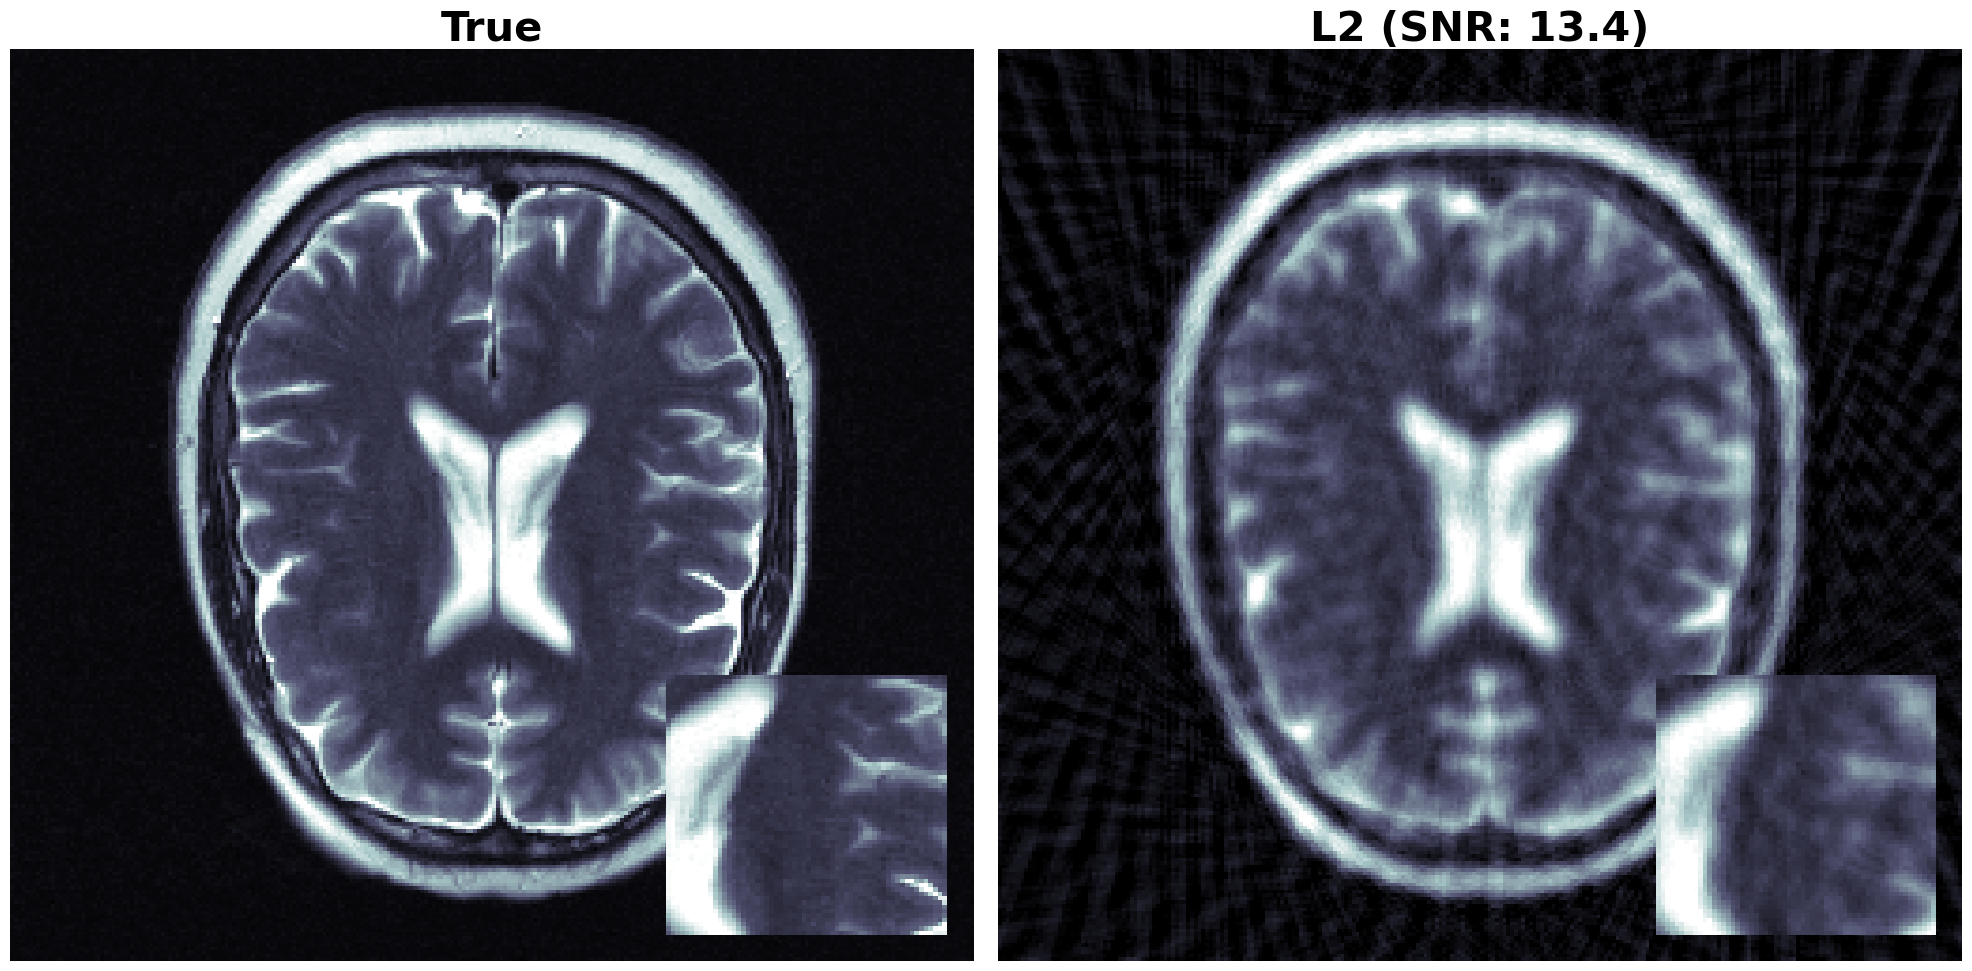

In [14]:
brainl2 = lsqr(Cop, sinogram.ravel(), iter_lim=30)[0]
brainl2 = brainl2.reshape(nx, ny)

plt_comparison(brain, brainl2, cmap='bone', clim=(0, 0.7), 
               titles=['True', 'L2'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)

## Least-squares regularized inversion

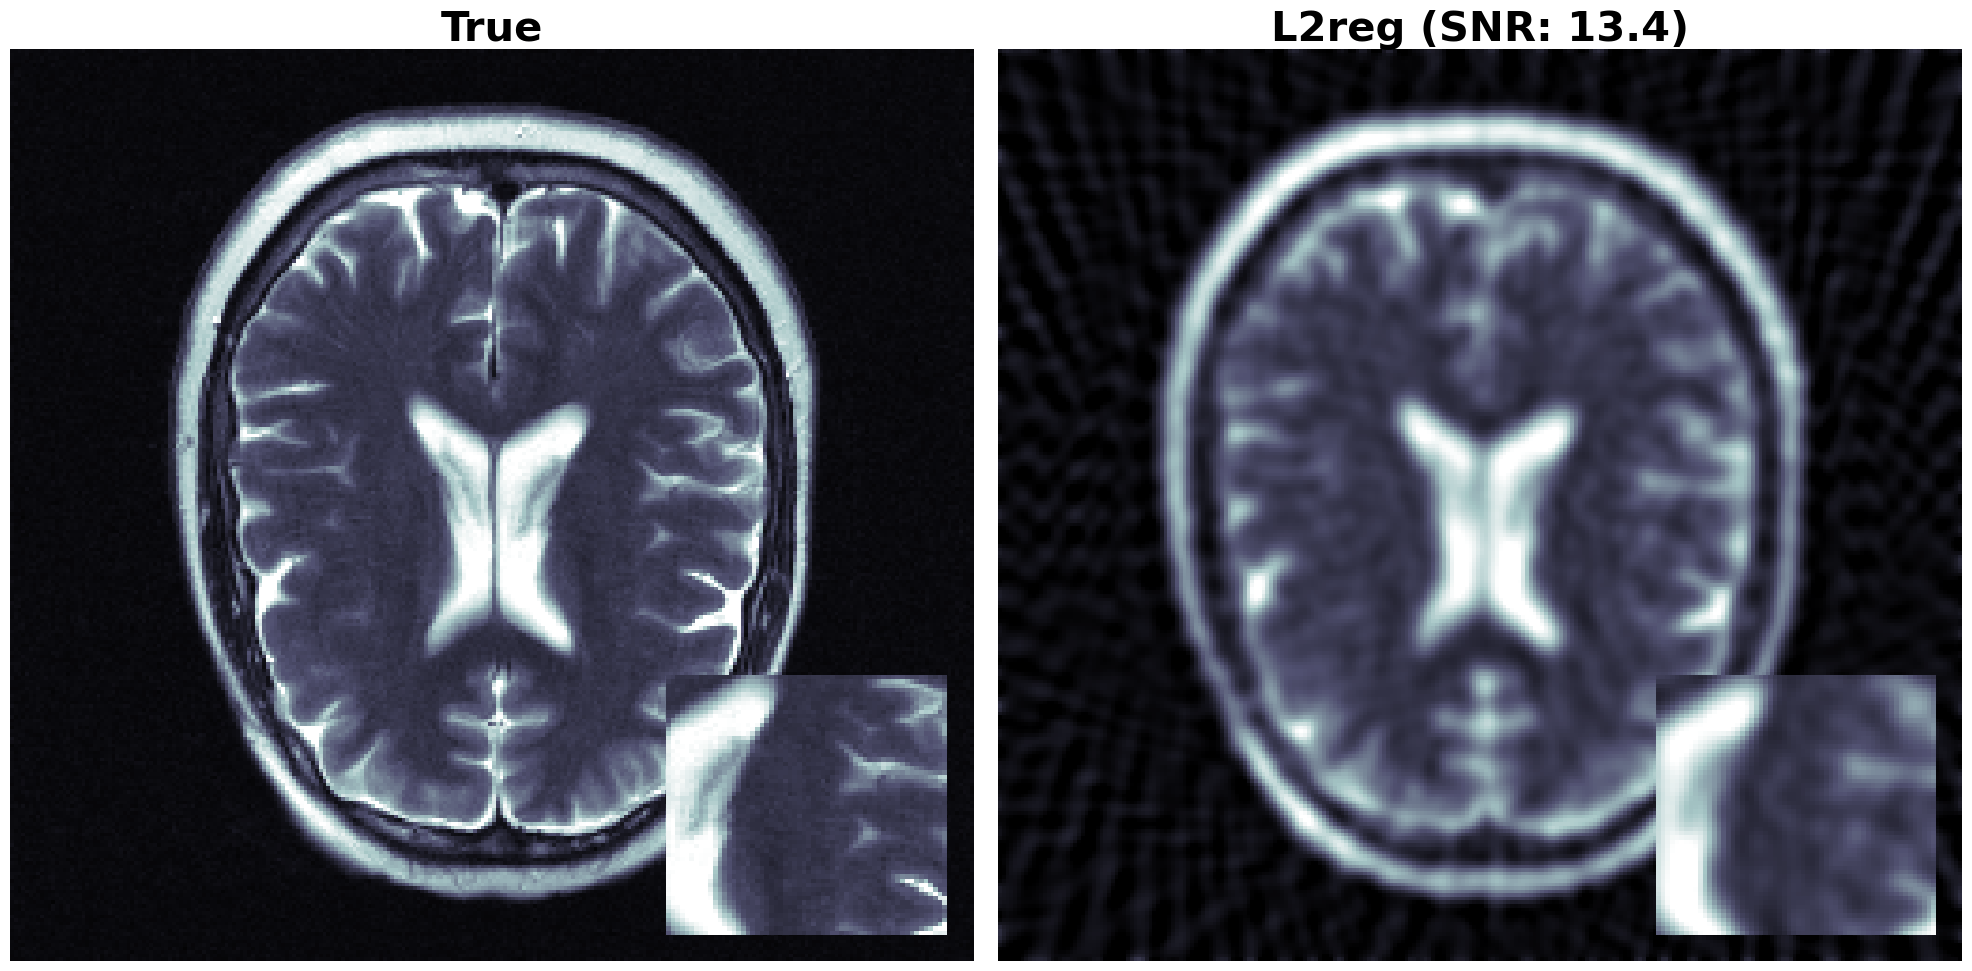

In [15]:
D2op = pylops.Laplacian(dims=(nx, ny), edge=True, dtype=np.float64)

brainl2reg = pylops.optimization.leastsquares.regularized_inversion(
    Cop, sinogram.ravel(), [D2op], epsRs=[1e1], **dict(iter_lim=20))[0]
brainl2reg = np.real(brainl2reg.reshape(nx, ny))

plt_comparison(brain, brainl2reg, cmap='bone', clim=(0, 0.7), 
               titles=['True', 'L2reg'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)

## TV regularized inversion

ADMM
---------------------------------------------------------
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
tau = 1.237500e-01	niter = 20

   Itn       x[0]          f           g       J = f + g
     1   4.08771e-02   6.544e+00   1.218e+02   1.283e+02
     2   4.69227e-02   2.659e+00   1.151e+02   1.178e+02
     3   4.44913e-02   1.487e+00   1.129e+02   1.143e+02
     4   4.13505e-02   1.300e+00   1.101e+02   1.114e+02
     5   3.85607e-02   1.255e+00   1.076e+02   1.089e+02
     6   3.70378e-02   1.210e+00   1.056e+02   1.068e+02
     7   3.67847e-02   1.183e+00   1.039e+02   1.051e+02
     8   3.70671e-02   1.165e+00   1.024e+02   1.036e+02
     9   3.73112e-02   1.145e+00   1.012e+02   1.023e+02
    10   3.66699e-02   1.129e+00   1.001e+02   1.012e+02
    11   3.62539e-02   1.123e+00   9.918e+01   1.003e+02
    12   3.55439e-02   1.110e+00   9.836e+01   9.947e+01
    13   3.49995e-02   1.108e+00   9.764e+01   9.874e+01
    14   3.45177e-02   1.100e+00   9.699e+01   

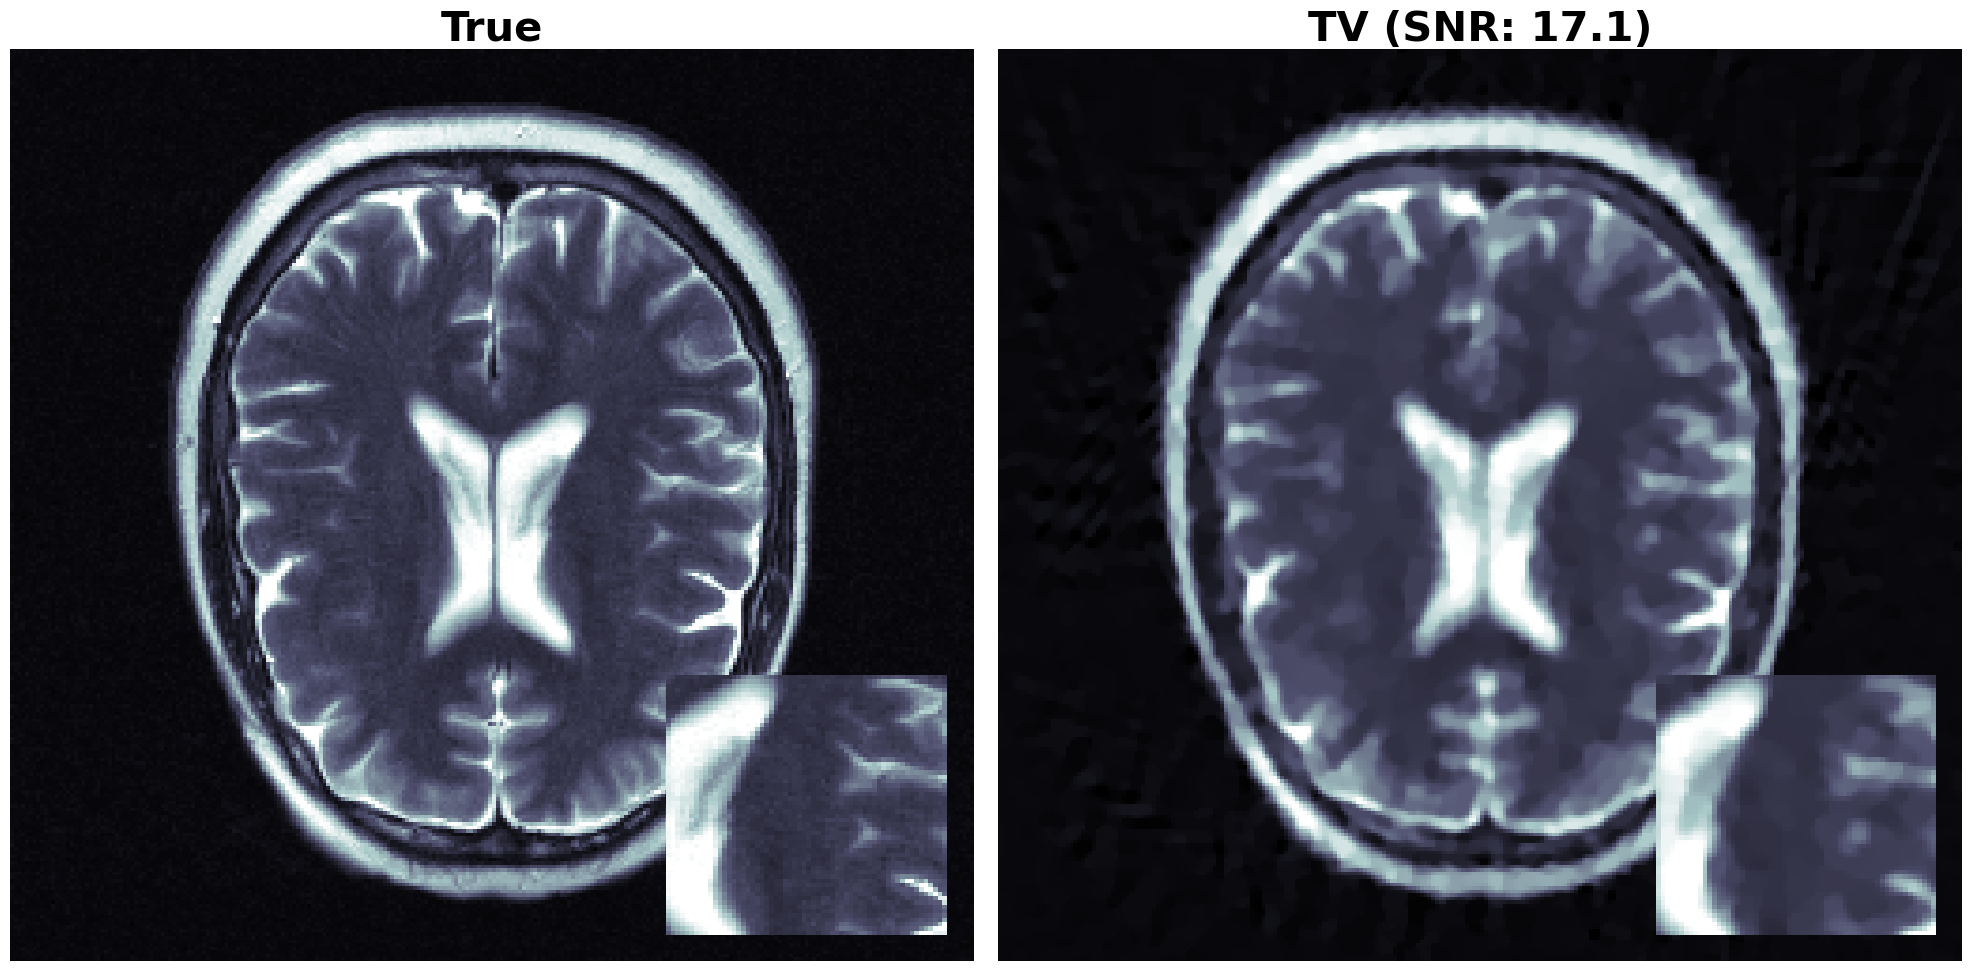

In [16]:
sigma=0.06
l1 = L21(ndim=2, sigma=sigma)
Dop = pylops.Gradient(dims=(nx, ny), edge=True, dtype=Cop.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.99 / L

braintv = ADMML2(l1, Cop, sinogram.ravel(), Dop, x0=np.zeros(nx*ny), tau=tau, 
                 niter=20, show=True, **dict(iter_lim=20))[0]
braintv = braintv.reshape(nx, ny)

plt_comparison(brain, braintv, cmap='bone', clim=(0, 0.7), 
               titles=['True', 'TV'], zoom=(100, 160, 130, 190),
               metricname='SNR', metric=snr)